In [ ]:
#| default_exp models.moment

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MOMENT

MOMENT is a family of open-source foundation models for time series forecasting. MOMENT uses a Transformer architecture, and works by learning embeddings of patches of time series and reconstructing the learned embeddings onto an output dimension to fulfil a set of time series tasks, such as forecasting, classification, anomaly detection and imputation. In this implementation, only the forecasting task is supported. This is a multivariate forecasting architecture. MOMENT does not support exogenous variables.

**References**<br>
-[Goswami, Mononito, Konrad Szafer, Arjun Choudhry, Yifu Cai, Shuo Li, and Artur Dubrawski. (2024). MOMENT: A Family of Open Time-Series Foundation Models. International Conference on Machine Learning, Vienna, Austria. PMLR 235](https://arxiv.org/pdf/2402.03885)<br>

![Figure 1. Overview of MOMENT.](imgs_models/moment.png)

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| export
from typing import Optional, Union

import warnings
import torch
import torch.nn as nn
import math
import numpy.typing as npt

from copy import deepcopy
from dataclasses import dataclass
from argparse import Namespace
from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_multivariate import BaseMultivariate
try:
    from transformers import T5Config, T5EncoderModel, T5Model
    from huggingface_hub import PyTorchModelHubMixin
    IS_TRANSFORMERS_INSTALLED = True
except:
    IS_TRANSFORMERS_INSTALLED = False


## 1. Auxiliary Functions

### RevIN

In [ ]:
#| exporti
def nanvar(tensor, dim=None, keepdim=False):
    tensor_mean = tensor.nanmean(dim=dim, keepdim=True)
    output = (tensor - tensor_mean).square().nanmean(dim=dim, keepdim=keepdim)
    return output


def nanstd(tensor, dim=None, keepdim=False):
    output = nanvar(tensor, dim=dim, keepdim=keepdim)
    output = output.sqrt()
    return output

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps: float = 1e-5, affine: bool = False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine

        if self.affine:
            self._init_params()

    def forward(self, x: torch.Tensor, mode: str = "norm", mask: torch.Tensor = None):
        """
        :param x: input tensor of shape (batch_size, n_channels, seq_len)
        :param mode: 'norm' or 'denorm'
        :param mask: input mask of shape (batch_size, seq_len)
        :return: RevIN transformed tensor
        """
        if mode == "norm":
            self._get_statistics(x, mask=mask)
            x = self._normalize(x)
        elif mode == "denorm":
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(1, self.num_features, 1))
        self.affine_bias = nn.Parameter(torch.zeros(1, self.num_features, 1))

    def _get_statistics(self, x, mask=None):
        """
        x    : batch_size x n_channels x seq_len
        mask : batch_size x seq_len
        """
        if mask is None:
            mask = torch.ones((x.shape[0], x.shape[-1]))
        n_channels = x.shape[1]
        mask = mask.unsqueeze(1).repeat(1, n_channels, 1).bool()
        # Set masked positions to NaN, and unmasked positions are taken from x
        masked_x = torch.where(mask, x, torch.nan)
        self.mean = torch.nanmean(masked_x, dim=-1, keepdim=True).detach()
        self.stdev = nanstd(masked_x, dim=-1, keepdim=True).detach() + self.eps
        # self.stdev = torch.sqrt(
        #     torch.var(masked_x, dim=-1, keepdim=True) + self.eps).get_data().detach()
        # NOTE: By default not bessel correction

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev

        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

### Masking

In [ ]:
#| exporti
class Masking:
    def __init__(
        self, mask_ratio: float = 0.3, patch_len: int = 8, stride: Optional[int] = None
    ):
        """
        Indices with 0 mask are hidden, and with 1 are observed.
        """
        self.mask_ratio = mask_ratio
        self.patch_len = patch_len
        self.stride = patch_len if stride is None else stride

    @staticmethod
    def convert_seq_to_patch_view(
        mask: torch.Tensor, patch_len: int = 8, stride: Optional[int] = None
    ):
        """
        Input:
            mask : torch.Tensor of shape [batch_size x seq_len]
        Output
            mask : torch.Tensor of shape [batch_size x n_patches]
        """
        stride = patch_len if stride is None else stride
        mask = mask.unfold(dimension=-1, size=patch_len, step=stride)
        # mask : [batch_size x n_patches x patch_len]
        return (mask.sum(dim=-1) == patch_len).long()

    @staticmethod
    def convert_patch_to_seq_view(
        mask: torch.Tensor,
        patch_len: int = 8,
    ):
        """
        Input:
            mask : torch.Tensor of shape [batch_size x n_patches]
        Output:
            mask : torch.Tensor of shape [batch_size x seq_len]
        """
        return mask.repeat_interleave(patch_len, dim=-1)

    def generate_mask(self, x: torch.Tensor, input_mask: Optional[torch.Tensor] = None):
        """
        Input:
            x : torch.Tensor of shape
            [batch_size x n_channels x n_patches x patch_len] or
            [batch_size x n_channels x seq_len]
            input_mask: torch.Tensor of shape [batch_size x seq_len] or
            [batch_size x n_patches]
        Output:
            mask : torch.Tensor of shape [batch_size x seq_len]
        """
        if x.ndim == 4:
            return self._mask_patch_view(x, input_mask=input_mask)
        elif x.ndim == 3:
            return self._mask_seq_view(x, input_mask=input_mask)

    def _mask_patch_view(self, x, input_mask=None):
        """
        Input:
            x : torch.Tensor of shape
            [batch_size x n_channels x n_patches x patch_len]
            input_mask: torch.Tensor of shape [batch_size x seq_len]
        Output:
            mask : torch.Tensor of shape [batch_size x n_patches]
        """
        input_mask = self.convert_seq_to_patch_view(
            input_mask, self.patch_len, self.stride
        )
        n_observed_patches = input_mask.sum(dim=-1, keepdim=True)  # batch_size x 1

        batch_size, _, n_patches, _ = x.shape
        len_keep = torch.ceil(n_observed_patches * (1 - self.mask_ratio)).long()
        noise = torch.rand(
            batch_size, n_patches, device=x.device
        )  # noise in [0, 1], batch_size x n_channels x n_patches
        noise = torch.where(
            input_mask == 1, noise, torch.ones_like(noise)
        )  # only keep the noise of observed patches

        # Sort noise for each sample
        ids_shuffle = torch.argsort(
            noise, dim=1
        )  # Ascend: small is keep, large is remove
        ids_restore = torch.argsort(
            ids_shuffle, dim=1
        )  # ids_restore: [batch_size x n_patches]

        # Generate the binary mask: 0 is keep, 1 is remove
        mask = torch.zeros(
            [batch_size, n_patches], device=x.device
        )  # mask: [batch_size x n_patches]
        for i in range(batch_size):
            mask[i, : len_keep[i]] = 1

        # Unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return mask.long()

    def _mask_seq_view(self, x, input_mask=None):
        """
        Input:
            x : torch.Tensor of shape
            [batch_size x n_channels x seq_len]
            input_mask: torch.Tensor of shape [batch_size x seq_len]
        Output:
            mask : torch.Tensor of shape [batch_size x seq_len]
        """
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        mask = self._mask_patch_view(x, input_mask=input_mask)
        return self.convert_patch_to_seq_view(mask, self.patch_len).long()

### Embeddings

In [ ]:
#| exporti
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000, model_name="MOMENT"):
        super(PositionalEmbedding, self).__init__()
        self.model_name = model_name

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        ).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        if (
            self.model_name == "MOMENT"
            or self.model_name == "TimesNet"
            or self.model_name == "GPT4TS"
        ):
            return self.pe[:, : x.size(2)]
        else:
            return self.pe[:, : x.size(1)]

class PatchEmbedding(nn.Module):
    def __init__(
        self,
        d_model: int = 768,
        seq_len: int = 512,
        patch_len: int = 8,
        stride: int = 8,
        dropout: float = 0.1,
        add_positional_embedding: bool = False,
        value_embedding_bias: bool = False,
        orth_gain: float = 1.41,
    ):
        super(PatchEmbedding, self).__init__()
        self.patch_len = patch_len
        self.seq_len = seq_len
        self.stride = stride
        self.d_model = d_model
        self.add_positional_embedding = add_positional_embedding

        self.value_embedding = nn.Linear(patch_len, d_model, bias=value_embedding_bias)
        self.mask_embedding = nn.Parameter(torch.zeros(d_model))

        if orth_gain is not None:
            torch.nn.init.orthogonal_(self.value_embedding.weight, gain=orth_gain)
            if value_embedding_bias:
                self.value_embedding.bias.data.zero_()
            # torch.nn.init.orthogonal_(self.mask_embedding, gain=orth_gain) # Fails

        # Positional embedding
        if self.add_positional_embedding:
            self.position_embedding = PositionalEmbedding(d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        mask = Masking.convert_seq_to_patch_view(
            mask, patch_len=self.patch_len
        ).unsqueeze(-1)
        # mask : [batch_size x n_patches x 1]
        n_channels = x.shape[1]
        mask = (
            mask.repeat_interleave(self.d_model, dim=-1)
            .unsqueeze(1)
            .repeat(1, n_channels, 1, 1)
        )
        # mask : [batch_size x n_channels x n_patches x d_model]

        # Input encoding
        x = mask * self.value_embedding(x) + (1 - mask) * self.mask_embedding
        if self.add_positional_embedding:
            x = x + self.position_embedding(x)

        return self.dropout(x)
    
class Patching(nn.Module):
    def __init__(self, patch_len: int, stride: int):
        super().__init__()
        self.patch_len = patch_len
        self.stride = stride
        if self.stride != self.patch_len:
            warnings.warn(
                "Stride and patch length are not equal. "
                "This may lead to unexpected behavior."
            )

    def forward(self, x):
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        # x : [batch_size x n_channels x num_patch x patch_len]
        return x        

### Data

In [ ]:
#| exporti
class NamespaceWithDefaults(Namespace):
    @classmethod
    def from_namespace(cls, namespace):
        new_instance = cls()
        for attr in dir(namespace):
            if not attr.startswith("__"):
                setattr(new_instance, attr, getattr(namespace, attr))
        return new_instance

    def getattr(self, key, default=None):
        return getattr(self, key, default)

@dataclass
class TimeseriesOutputs:
    forecast: npt.NDArray = None
    anomaly_scores: npt.NDArray = None
    logits: npt.NDArray = None
    labels: Optional[str] = None
    input_mask: npt.NDArray = None
    pretrain_mask: npt.NDArray = None
    reconstruction: npt.NDArray = None
    embeddings: npt.NDArray = None
    metadata: Optional[dict] = None
    illegal_output: bool = False

@dataclass
class TASKS:
    RECONSTRUCTION: str = "reconstruction"
    FORECASTING: str = "forecasting"

### Moment

In [ ]:
#| exporti
SUPPORTED_HUGGINGFACE_MODELS = [
    "google/flan-t5-small",
    "google/flan-t5-base",
    "google/flan-t5-large",
    "google/flan-t5-xl",
    "google/flan-t5-xxl",
]

class PretrainHead(nn.Module):
    def __init__(
        self,
        d_model: int = 768,
        patch_len: int = 8,
        head_dropout: float = 0.1,
        orth_gain: float = 1.41,
    ):
        super().__init__()
        self.dropout = nn.Dropout(head_dropout)
        self.linear = nn.Linear(d_model, patch_len)

        if orth_gain is not None:
            torch.nn.init.orthogonal_(self.linear.weight, gain=orth_gain)
            self.linear.bias.data.zero_()

    def forward(self, x):
        x = self.linear(self.dropout(x))
        x = x.flatten(start_dim=2, end_dim=3)
        return x

class ForecastingHead(nn.Module):
    def __init__(
        self, head_nf: int = 768 * 64, forecast_horizon: int = 96, head_dropout: int = 0
    ):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=-2)
        self.dropout = nn.Dropout(head_dropout)
        self.linear = nn.Linear(head_nf, forecast_horizon)

    def forward(self, x, input_mask: torch.Tensor = None):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x

class MOMENT_module(nn.Module):
    def __init__(self, config: Union[Namespace, dict], **kwargs: dict):
        super().__init__()
        config = self._update_inputs(config, **kwargs)
        config = self._validate_inputs(config)
        self.config = config
        self.task_name = config.task_name
        self.seq_len = config.seq_len
        self.patch_len = config.patch_len

        self.normalizer = RevIN(
            num_features=1, affine=config.getattr("revin_affine", False)
        )
        self.tokenizer = Patching(
            patch_len=config.patch_len, stride=config.patch_stride_len
        )
        self.patch_embedding = PatchEmbedding(
            d_model=config.d_model,
            seq_len=config.seq_len,
            patch_len=config.patch_len,
            stride=config.patch_stride_len,
            dropout=config.getattr("dropout", 0.1),
            add_positional_embedding=config.getattr("add_positional_embedding", True),
            value_embedding_bias=config.getattr("value_embedding_bias", False),
            orth_gain=config.getattr("orth_gain", 1.41),
        )
        self.mask_generator = Masking(mask_ratio=config.getattr("mask_ratio", 0.0))
        self.encoder = self._get_transformer_backbone(config)
        self.head = self._get_head(self.task_name)

    def _update_inputs(
        self, config: Union[Namespace, dict], **kwargs: dict
    ) -> NamespaceWithDefaults:
        if isinstance(config, dict) and "model_kwargs" in kwargs:
            return NamespaceWithDefaults(**{**config, **kwargs["model_kwargs"]})
        else:
            return NamespaceWithDefaults.from_namespace(config)

    def _validate_inputs(self, config: NamespaceWithDefaults) -> NamespaceWithDefaults:
        if (
            config.d_model is None
            and config.transformer_backbone in SUPPORTED_HUGGINGFACE_MODELS
        ):
            config.d_model = self.get_huggingface_model_dimensions(
                config.transformer_backbone
            )
        elif config.d_model is None:
            raise ValueError(
                "d_model must be specified if transformer backbone "
                "unless transformer backbone is a Huggingface model."
            )

        if config.transformer_type not in [
            "encoder_only",
            "decoder_only",
            "encoder_decoder",
        ]:
            raise ValueError(
                "transformer_type must be one of "
                "['encoder_only', 'decoder_only', 'encoder_decoder']"
            )

        if config.patch_stride_len != config.patch_len:
            warnings.warn("Patch stride length is not equal to patch length.")
        return config

    def _get_head(self, task_name: str) -> nn.Module:
        if task_name == TASKS.RECONSTRUCTION:
            return PretrainHead(
                self.config.d_model,
                self.config.patch_len,
                self.config.getattr("dropout", 0.1),
                self.config.getattr("orth_gain", 1.41),
            )
        elif task_name == TASKS.FORECASTING:
            num_patches = (
                max(self.config.seq_len, self.config.patch_len) - self.config.patch_len
            ) // self.config.patch_stride_len + 1
            self.head_nf = self.config.d_model * num_patches
            return ForecastingHead(
                self.head_nf,
                self.config.forecast_horizon,
                self.config.getattr("head_dropout", 0.1),
            )
        else:
            raise NotImplementedError(f"Task {task_name} not implemented.")

    def _get_transformer_backbone(self, config) -> nn.Module:
        if config.getattr("randomly_initialize_backbone", False):
            model_config = T5Config.from_pretrained(config.transformer_backbone)
            transformer_backbone = T5Model(model_config)
        else:
            transformer_backbone = T5EncoderModel.from_pretrained(
                config.transformer_backbone
            )

        transformer_backbone = transformer_backbone.get_encoder()
        return transformer_backbone

    def __call__(self, *args, **kwargs) -> TimeseriesOutputs:
        return self.forward(*args, **kwargs)

    @staticmethod
    def get_huggingface_model_dimensions(model_name):
        config = T5Config.from_pretrained(model_name)
        return config.d_model

    def reconstruction(
        self,
        x_enc: torch.Tensor,
        input_mask: torch.Tensor = None,
        mask: torch.Tensor = None,
        **kwargs,
    ) -> TimeseriesOutputs:
        batch_size, n_channels, _ = x_enc.shape

        if mask is None:
            mask = self.mask_generator.generate_mask(x=x_enc, input_mask=input_mask)
            mask = mask.to(x_enc.device)  # mask: [batch_size x seq_len]

        x_enc = self.normalizer(x=x_enc, mask=mask * input_mask, mode="norm")
        # Prevent too short time-series from causing NaNs
        x_enc = torch.nan_to_num(x_enc, nan=0, posinf=0, neginf=0)

        x_enc = self.tokenizer(x=x_enc)
        enc_in = self.patch_embedding(x_enc, mask=mask)

        n_patches = enc_in.shape[2]
        enc_in = enc_in.reshape(
            (batch_size * n_channels, n_patches, self.config.d_model)
        )

        patch_view_mask = Masking.convert_seq_to_patch_view(input_mask, self.patch_len)
        attention_mask = patch_view_mask.repeat_interleave(n_channels, dim=0)
        if self.config.transformer_type == "encoder_decoder":
            outputs = self.encoder(
                inputs_embeds=enc_in,
                decoder_inputs_embeds=enc_in,
                attention_mask=attention_mask,
            )
        else:
            outputs = self.encoder(inputs_embeds=enc_in, attention_mask=attention_mask)
        enc_out = outputs.last_hidden_state

        enc_out = enc_out.reshape((-1, n_channels, n_patches, self.config.d_model))

        dec_out = self.head(enc_out)  # [batch_size x n_channels x seq_len]
        dec_out = self.normalizer(x=dec_out, mode="denorm")

        if self.config.getattr("debug", False):
            illegal_output = self._check_model_weights_for_illegal_values()
        else:
            illegal_output = None

        return TimeseriesOutputs(
            input_mask=input_mask,
            reconstruction=dec_out,
            pretrain_mask=mask,
            illegal_output=illegal_output,
        )

    def forecast(
        self, x_enc: torch.Tensor, input_mask: torch.Tensor = None, **kwargs
    ) -> TimeseriesOutputs:
        batch_size, n_channels, seq_len = x_enc.shape

        x_enc = self.normalizer(x=x_enc, mask=input_mask, mode="norm")
        x_enc = torch.nan_to_num(x_enc, nan=0, posinf=0, neginf=0)

        x_enc = self.tokenizer(x=x_enc)
        enc_in = self.patch_embedding(x_enc, mask=torch.ones_like(input_mask))

        n_patches = enc_in.shape[2]
        enc_in = enc_in.reshape(
            (batch_size * n_channels, n_patches, self.config.d_model)
        )

        patch_view_mask = Masking.convert_seq_to_patch_view(input_mask, self.patch_len)
        attention_mask = patch_view_mask.repeat_interleave(n_channels, dim=0)
        outputs = self.encoder(inputs_embeds=enc_in, attention_mask=attention_mask)
        enc_out = outputs.last_hidden_state
        enc_out = enc_out.reshape((-1, n_channels, n_patches, self.config.d_model))
        # [batch_size x n_channels x n_patches x d_model]

        dec_out = self.head(enc_out)  # [batch_size x n_channels x forecast_horizon]
        dec_out = self.normalizer(x=dec_out, mode="denorm")

        return TimeseriesOutputs(input_mask=input_mask, forecast=dec_out)

    def forward(
        self,
        x_enc: torch.Tensor,
        mask: torch.Tensor = None,
        input_mask: torch.Tensor = None,
        **kwargs,
    ) -> TimeseriesOutputs:
        if input_mask is None:
            input_mask = torch.ones_like(x_enc[:, 0, :])

        if self.task_name == TASKS.RECONSTRUCTION:
            return self.reconstruction(
                x_enc=x_enc, mask=mask, input_mask=input_mask, **kwargs
            )
        elif self.task_name == TASKS.FORECASTING:
            return self.forecast(x_enc=x_enc, input_mask=input_mask, **kwargs)
        else:
            raise NotImplementedError(f"Task {self.task_name} not implemented.")

if IS_TRANSFORMERS_INSTALLED:
    class MOMENTPipeline(MOMENT_module, PyTorchModelHubMixin):
        def __init__(self, config: Union[Namespace, dict], **kwargs: dict):
            self._validate_model_kwargs(**kwargs)
            self.new_task_name = kwargs.get("model_kwargs", {}).pop(
                "task_name", TASKS.RECONSTRUCTION
            )
            super().__init__(config, **kwargs)

        def _validate_model_kwargs(self, **kwargs: dict) -> None:
            kwargs = deepcopy(kwargs)
            kwargs.setdefault("model_kwargs", {"task_name": TASKS.RECONSTRUCTION})
            kwargs["model_kwargs"].setdefault("task_name", TASKS.RECONSTRUCTION)
            config = Namespace(**kwargs["model_kwargs"])

            if config.task_name == TASKS.FORECASTING:
                if not hasattr(config, "forecast_horizon"):
                    raise ValueError(
                        "forecast_horizon must be specified for long-horizon forecasting."
                    )

        def init(self) -> None:
            if self.new_task_name != TASKS.RECONSTRUCTION:
                self.task_name = self.new_task_name
                self.head = self._get_head(self.new_task_name)


## 2. MOMENT

In [ ]:
#| export
class MOMENT(BaseMultivariate):
    """ MOMENT
    
    MOMENT is a family of open-source foundation models for time series forecasting. MOMENT uses a Transformer architecture, and works by learning embeddings of patches of time series and reconstructing the learned embeddings onto an output dimension to fulfil a set of time series tasks, such as forecasting, classification, anomaly detection and imputation. In this implementation, only the forecasting task is supported. This is a multivariate forecasting architecture.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `n_series`: int, number of time-series.<br>
    `model`: str="AutonLab/MOMENT-1-large", which model to use. If None, will train a model using HF T5 pretrained models.<br> 
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>
    - [Goswami, Mononito, Konrad Szafer, Arjun Choudhry, Yifu Cai, Shuo Li, and Artur Dubrawski. (2024). MOMENT: A Family of Open Time-Series Foundation Models. International Conference on Machine Learning, Vienna, Austria. PMLR 235](https://arxiv.org/pdf/2402.03885)
    """
    # Class attributes
    SAMPLING_TYPE = 'multivariate'
    
    def __init__(self,
                 h: int,
                 input_size: int,
                 n_series: int,
                 model = "AutonLab/MOMENT-1-large",
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 5,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 **trainer_kwargs):

        super(MOMENT, self).__init__(
            h=h,
            input_size=input_size,
            n_series=n_series,
            futr_exog_list=futr_exog_list,
            hist_exog_list=hist_exog_list,
            stat_exog_list=stat_exog_list,
            loss=loss,
            valid_loss=valid_loss,
            max_steps=max_steps,
            learning_rate=learning_rate,
            num_lr_decays=num_lr_decays,
            early_stop_patience_steps=early_stop_patience_steps,
            val_check_steps=val_check_steps,
            batch_size=batch_size,
            step_size=step_size,
            scaler_type=scaler_type,
            random_seed=random_seed,
            num_workers_loader=num_workers_loader,
            drop_last_loader=drop_last_loader,
            optimizer=optimizer,
            optimizer_kwargs=optimizer_kwargs,
            **trainer_kwargs
        )
               

        #----------------------------------- Parse dimensions -----------------------------------#
        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)        

        if stat_exog_list is not None:
            raise Exception("MOMENT does not support static exogenous variables")
        if futr_exog_list is not None:
            raise Exception("MOMENT does not support future exogenous variables")
        if hist_exog_list is not None:
            raise Exception("MOMENT does not support historical exogenous variables")

        #---------------------------------- Instantiate Model -----------------------------------#
        if not IS_TRANSFORMERS_INSTALLED:
            raise ImportError("Please install `transformers` to use MOMENT")
        
        model = MOMENTPipeline.from_pretrained(
            "AutonLab/MOMENT-1-large", 
            model_kwargs={
                'task_name': 'forecasting',
                'forecast_horizon': h,
                'seq_len': input_size,
            },
        )
        model.init()
        self.model = model

    def forward(self, windows_batch):
        # Parse windows_batch
        x             = windows_batch['insample_y']                     #   [B, L, n_series (N)]
        x_enc         = x.permute(0, 2, 1)                              #   [B, L, N] -> [B, N, L]

        #  Run MOMENT
        output = self.model(x_enc)
        
        # Map to output domain
        output = output.forecast.permute(0, 2, 1)                       # [B, N, h] -> [B, h, N]
        forecast = self.loss.domain_map(output)
        
        # domain_map might have squeezed the last dimension in case n_series == 1
        # Note that this fails in case of a tuple loss, but Multivariate does not support tuple losses yet.
        if forecast.ndim == 2:
            return forecast.unsqueeze(-1)
        else:
            return forecast

In [ ]:
show_doc(MOMENT)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/moment.py#L646){target="_blank" style="float:right; font-size:smaller"}

### MOMENT

>      MOMENT (h:int, input_size:int, n_series:int,
>              model='AutonLab/MOMENT-1-large', futr_exog_list=None,
>              hist_exog_list=None, stat_exog_list=None, loss=MAE(),
>              valid_loss=None, max_steps:int=5, learning_rate:float=0.001,
>              num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>              val_check_steps:int=100, batch_size:int=32, step_size:int=1,
>              scaler_type:str='identity', random_seed:int=1,
>              num_workers_loader:int=0, drop_last_loader:bool=False,
>              optimizer=None, optimizer_kwargs=None, **trainer_kwargs)

MOMENT

MOMENT is a family of open-source foundation models for time series forecasting. MOMENT uses a Transformer architecture, and works by learning embeddings of patches of time series and reconstructing the learned embeddings onto an output dimension to fulfil a set of time series tasks, such as forecasting, classification, anomaly detection and imputation. In this implementation, only the forecasting task is supported. This is a multivariate forecasting architecture.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`n_series`: int, number of time-series.<br>
`model`: str="AutonLab/MOMENT-1-large", which model to use. If None, will train a model using HF T5 pretrained models.<br> 
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References**<br>
- [Goswami, Mononito, Konrad Szafer, Arjun Choudhry, Yifu Cai, Shuo Li, and Artur Dubrawski. (2024). MOMENT: A Family of Open Time-Series Foundation Models. International Conference on Machine Learning, Vienna, Austria. PMLR 235](https://arxiv.org/pdf/2402.03885)

In [ ]:
show_doc(MOMENT.fit, name='MOMENT.fit')

---

### MOMENT.fit

>      MOMENT.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                  distributed_config=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(MOMENT.predict, name='MOMENT.predict')

---

### MOMENT.predict

>      MOMENT.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                      **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MAE

Seed set to 1
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\common\_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type           | Params
------------------------------------------
0 | loss   | MAE            | 0     
1 | padder | ConstantPad1d  | 0     
2 | scaler | TemporalNorm   | 0     
3 | model  | MOMENTPipeline | 341 M 
------------------------------------------
341 M     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5` reached.
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:352: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:404: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\core.py:198: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


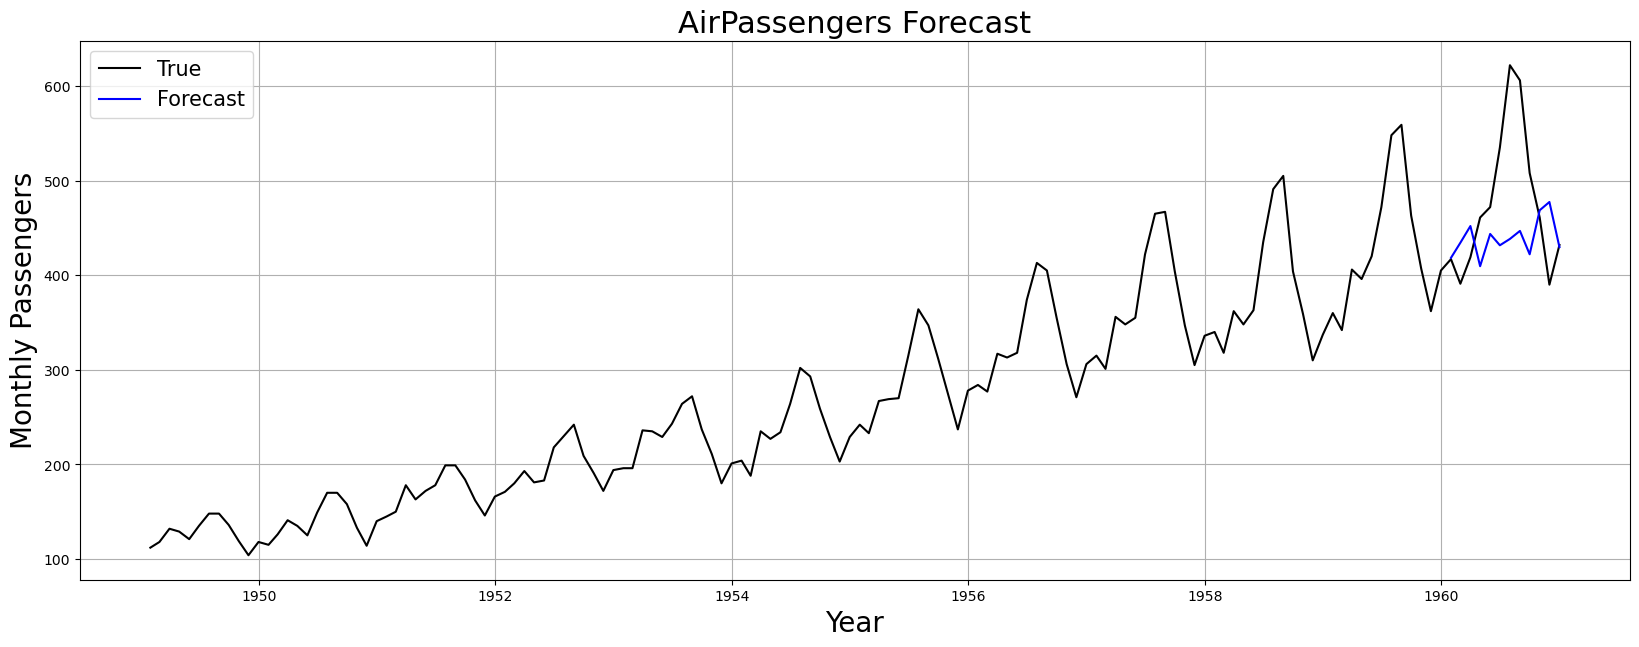

In [ ]:
#| eval: false
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = MOMENT(h=12,
                input_size=24,
                n_series=2,
                scaler_type='identity',
                max_steps=5,
                )

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['MOMENT'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
#| eval: false
fcst = NeuralForecast(models=[model], freq='M')
forecasts = fcst.cross_validation(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=2, step_size=12)

c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\common\_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.

  | Name   | Type           | Params
------------------------------------------
0 | loss   | MAE            | 0     
1 | padder | ConstantPad1d  | 0     
2 | scaler | TemporalNorm   | 0     
3 | model  | MOMENTPipeline | 341 M 
------------------------------------------
341 M     Trainable params
0         Non-trainable params
341 M     Total params
1,365.109 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\OneDrive\Phd\Repositories\neuralforecast\neuralforecast\core.py:198: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


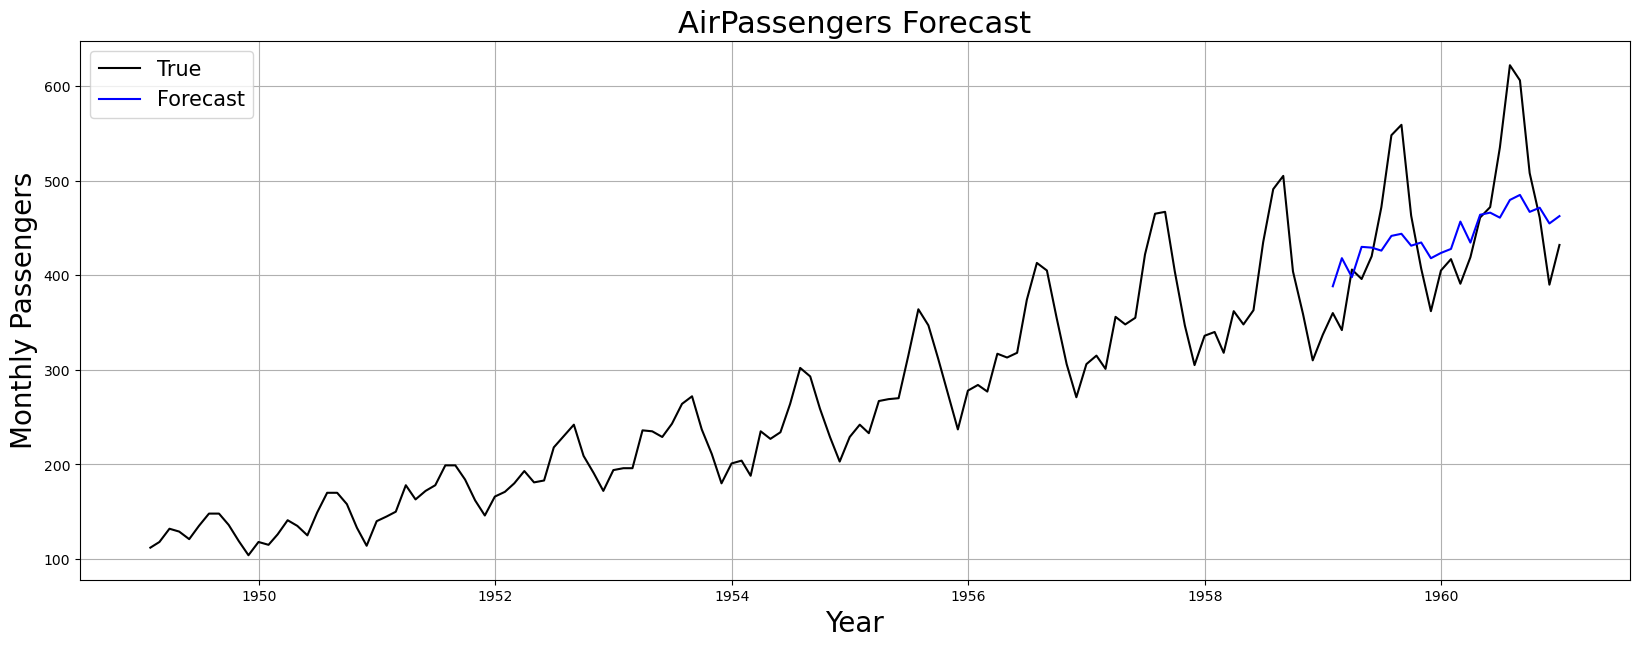

In [ ]:
#| eval: false
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.loc['Airline1']
Y_df = AirPassengersPanel[AirPassengersPanel['unique_id']=='Airline1']

plt.plot(Y_df['ds'], Y_df['y'], c='black', label='True')
plt.plot(Y_hat_df['ds'], Y_hat_df['MOMENT'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()